In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Flatten, Dense, Dropout, Activation
import keras
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.regularizers import l2
from tqdm import tqdm_notebook as tqdm 

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
dim = 64
num_classes = 15
maxepoches = 30
batch_size = 50

DATASET_PATH = '../input/15-scene/15-Scene'
one_hot_lookup = np.eye(num_classes)
dataset_x = []
dataset_y = []
for category in sorted(os.listdir(DATASET_PATH)):
    for fname in os.listdir(DATASET_PATH+"/"+category):
        img = cv2.imread(DATASET_PATH+"/"+category+'/'+fname, 2)
        img = cv2.resize(img, (dim,dim))
        dataset_x.append(np.reshape(img, [dim,dim,1]))
        dataset_y.append(np.reshape(one_hot_lookup[int(category)], [num_classes]))

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

"""shuffle dataset"""
p = np.random.permutation(len(dataset_x))
dataset_x = dataset_x[p]
dataset_y = dataset_y[p]
        
test_x = dataset_x[:int(len(dataset_x)/10)]
test_y = dataset_y[:int(len(dataset_x)/10)]
train_x = dataset_x[int(len(dataset_x)/10):]
train_y = dataset_y[int(len(dataset_x)/10):]

train_y2 = keras.utils.to_categorical(train_y).astype('float32')
test_y2 = keras.utils.to_categorical(test_y).astype('float32')

In [3]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(4037, 64, 64, 1)
(4037, 15)
(448, 64, 64, 1)
(448, 15)


In [4]:
img_input = Input(shape = train_x.shape[1:]) 

model1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
model1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(model1)
model1 = MaxPooling2D((3, 3), strides=(2, 2), name='block1_pool')(model1)

# Block 2
model1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(model1)
model1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(model1)
model1 = MaxPooling2D((3, 3), strides=(2, 2), name='block2_pool')(model1)

# Block 3
model1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(model1)
model1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(model1)
model1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(model1)
model1 = MaxPooling2D((3, 3), strides=(2, 2), name='block3_pool')(model1)

# Top layers
model1 = Flatten(name='flatten')(model1)
model1 = Dense(1024, activation='relu')(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(1024, activation='relu')(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(num_classes, activation='softmax')(model1)

model = Model(img_input, model1)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 31, 31, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 31, 31, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)

In [5]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer = RMSprop())

hist = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=100, verbose=1, epochs=maxepoches)

Instructions for updating:
Use tf.cast instead.
Train on 4037 samples, validate on 448 samples
Epoch 1/30
4037/4037 [==============================] - 6s 2ms/step - loss: 3.2944 - acc: 0.0822 - val_loss: 2.7017 - val_acc: 0.0848
Epoch 2/30
4037/4037 [==============================] - 2s 565us/step - loss: 2.6898 - acc: 0.0946 - val_loss: 2.6229 - val_acc: 0.1205
Epoch 3/30
4037/4037 [==============================] - 2s 565us/step - loss: 2.5180 - acc: 0.1605 - val_loss: 3.0084 - val_acc: 0.0848
Epoch 4/30
4037/4037 [==============================] - 2s 563us/step - loss: 2.3989 - acc: 0.1997 - val_loss: 2.3561 - val_acc: 0.2344
Epoch 5/30
4037/4037 [==============================] - 2s 566us/step - loss: 2.0678 - acc: 0.2995 - val_loss: 1.8029 - val_acc: 0.3929
Epoch 6/30
4037/4037 [==============================] - 2s 565us/step - loss: 1.7892 - acc: 0.3887 - val_loss: 1.7058 - val_acc: 0.3906
Epoch 7/30
4037/4037 [==============================] - 2s 564us/step - loss: 1.6223 - acc:

In [6]:
score = model.evaluate(test_x, test_y)
print("Training Accuracy: %.2f%%" % (hist.history['acc'][maxepoches - 1]*100))
print("Testing Accuracy: %.2f%%" % (score[1]*100))

448/448 [==============================] - 0s 344us/step
Training Accuracy: 96.11%
Testing Accuracy: 62.28%


Saved model to disk


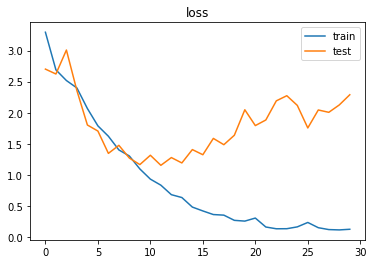

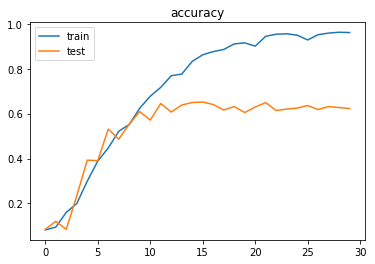

In [7]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.savefig("loss7.png",dpi=300,format="png")
plt.figure()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.savefig("accuracy7.png",dpi=300,format="png")
model_json = model.to_json()
with open("model7.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model7.h5")
print("Saved model to disk")